<strong><b><font size="5">Web Scraping e Análise de Dados</font></b></strong>

<strong><b><font size="5">Laboratório 2</font></b></strong>

<strong><b><font size="4">Web Scraping e Análise Estatística - Avaliando o Desempenho dos Participantes em Corridas de 10 KM com Dados de Sensores RFID</font></b></strong>

## Definição do Problema

Neste Laboratório vamos coletar dados reais de participantes de uma corrida de 10 KM realizada em Hillsboro no Oregon, EUA, em junho de 2017. 

Resumo da corrida:

- Pessoas que completaram a corrida: 577
- Homens: 414
- Mulheres: 163

O objetivo desta análise é encontrar:
    
- O tempo médio de conclusão da corrida.
- Se os tempos de chegada dos corredores seguem uma distribuição normal.
- Analisar se há diferença de desempenho entre homens e mulheres.

Os tempos registrados na corrida (bem como outros dados) são bem precisos pois os participantes usaram sensores RFID de onde os dados foram extraídos e disponibilizados na web. Mais detalhes sobre o uso dos sensores RFID aqui:

https://www.hubertiming.com/runners/faq

## Fonte de Dados

Como fonte de dados usaremos o web site <a href="https://www.hubertiming.com/">Huber Timing</a> que contém o resultado das corridas que acontecem nos EUA, bem como a agenda de novos eventos.

Aqui a página com o resultado da corrida que faremos a análise:

https://www.hubertiming.com/results/2017GPTR10K

## Carregando os Pacotes Usados Neste Jupyter Notebook

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão Python:', python_version())

Versão Python: 3.7.3


In [ ]:
# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [2]:
# Usaremos o pacote Pingouin para algumas das análises estatísticas ( Teste de normalidade)
# https://pingouin-stats.org/index.html
!pip install -q pingouin

In [ ]:
# Imports
import re
import requests
import matplotlib as m
import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup as bs
from urllib.request import urlopen
from scipy import stats

# Imports para formatação dos gráficos
sns.set_style('whitegrid')
%matplotlib inline

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark --iversions

matplotlib 3.2.1
numpy      1.18.4
re         2.2.1
pandas     1.0.4
pingouin   0.3.6
requests   2.21.0
seaborn    0.10.1



## Parte 1: Web Scraping

In [15]:
# Definindo a URL com o resultado da corrida
url = 'https://www.hubertiming.com/results/2017GPTR10K'

In [23]:
# Abre a conexão com a url
html = urlopen(url)

In [18]:
# Check Status da conexão
html.status

200

Existem várias formas de se aplicar o parser utilizando beautifulsoup. Abaixo vou utilizar uma forma rápida de parser: lxml.

- Quando o documento HTML está perfeitamente formatado, o resultado de cada parser aplicado será sempre o mesmo. Porém quando o documento não está formatado da devida forma, o resultado pode ser diferente.

In [19]:
# Extrai o código HTML
soup = bs(html,'lxml')

In [26]:
soup


<!DOCTYPE html>

<html>
<head>
<meta content="Race results for the 2017 Intel Great Place to Run \ Urban Clash Games!" property="og:title"/>
<meta content="Results of the 2017 Intel Great Place to Run \ Urban Clash Games at Hillsboro Stadium in Hillsboro, OR" property="og:description"/>
<meta content="https://www.hubertiming.com/results/2017GPTRForResults.jpg" property="og:image"/>
<meta content="https://www.hubertiming.com/results/2017GPTR10K" property="og:url"/>
<meta content="width=device-width, initial-scale=1, shrink-to-fit=no" name="viewport"/>
<title>Race results for the 2017 Intel Great Place to Run \ Urban Clash Games!</title>
<link crossorigin="anonymous" href="https://stackpath.bootstrapcdn.com/bootstrap/4.2.1/css/bootstrap.min.css" rel="stylesheet"/>
<link href="https://use.fontawesome.com/releases/v5.13.0/css/all.css" rel="stylesheet"/>
<link href="//cdn.rawgit.com/noelboss/featherlight/1.7.11/release/featherlight.min.css" rel="stylesheet" type="text/css">
<link href="//c

In [101]:
# Vamos visualizar as 10 primeiras linhas
linhas = soup.find_all('tr')
print(linhas[:10])

[<tr colspan="2">
<b>10K:</b>
</tr>, <tr>
<td>Finishers:</td>
<td>577</td>
</tr>, <tr>
<td>Male:</td>
<td>414</td>
</tr>, <tr>
<td>Female:</td>
<td>163</td>
</tr>, <tr class="header">
<th>Place</th>
<th>Bib</th>
<th>Name</th>
<th>Gender</th>
<th>City</th>
<th>State</th>
<th>Chip Time</th>
<th>Chip Pace</th>
<th>Gun Time</th>
<th>Team</th>
</tr>, <tr>
<td>1</td>
<td>814</td>
<td>

                    JARED WILSON

                </td>
<td>M</td>
<td>TIGARD</td>
<td>OR</td>
<td>36:21</td>
<td>5:51</td>
<td>36:24</td>
<td></td>
</tr>, <tr>
<td>2</td>
<td>573</td>
<td>

                    NATHAN A SUSTERSIC

                </td>
<td>M</td>
<td>PORTLAND</td>
<td>OR</td>
<td>36:42</td>
<td>5:55</td>
<td>36:45</td>
<td>
<img class="teamThumbs" src="/teamLogoThumbnail/logo?teamName=INTEL%20TEAM%20F&amp;raceId=1251&amp;state=OR"/>
                            INTEL TEAM F
                        </td>
</tr>, <tr>
<td>3</td>
<td>687</td>
<td>

                    FRANCISCO MAYA

              

## Parte 2:Limpeza e Transformação

Começaremos obtendo todas as linhas da tabela em forma de lista e depois converteremos essa lista em um dataframe para facilitar a manipulação.

Com expressões regulares em Python, vamos extrair os dados das tags HTML.

In [39]:
# Lista vazia para receber as linhas
lista_linhas = []

In [40]:
# Loop
for linha in linhas:
    cells = linha.find_all('td')
    str_cells = str(cells)
    clean = re.compile('<.*?>')
    clean2 = (re.sub(clean, '', str_cells))
    lista_linhas.append(clean2)

In [42]:
print(lista_linhas)

['[]', '[Finishers:, 577]', '[Male:, 414]', '[Female:, 163]', '[]', '[1, 814, \r\n\r\n                    JARED WILSON\r\n\r\n                , M, TIGARD, OR, 36:21, 5:51, 36:24, ]', '[2, 573, \r\n\r\n                    NATHAN A SUSTERSIC\r\n\r\n                , M, PORTLAND, OR, 36:42, 5:55, 36:45, \n\r\n                            INTEL TEAM F\r\n                        ]', '[3, 687, \r\n\r\n                    FRANCISCO MAYA\r\n\r\n                , M, PORTLAND, OR, 37:44, 6:05, 37:48, ]', '[4, 623, \r\n\r\n                    PAUL MORROW\r\n\r\n                , M, BEAVERTON, OR, 38:34, 6:13, 38:37, ]', '[5, 569, \r\n\r\n                    DEREK G OSBORNE\r\n\r\n                , M, HILLSBORO, OR, 39:21, 6:20, 39:24, \n\r\n                            INTEL TEAM F\r\n                        ]', '[6, 642, \r\n\r\n                    JONATHON TRAN\r\n\r\n                , M, PORTLAND, OR, 39:49, 6:25, 39:55, ]', '[7, 144, \r\n\r\n                    GEORGE TOTONCHY\r\n\r\n          

Convertemos a lista em um dataframe e obtemos uma visão rápida das 10 primeiras linhas usando o Pandas.

In [43]:
# Convertemos a lista em dataframe
df = pd.DataFrame(lista_linhas)

In [44]:
df.head(10)

,0
0,[]
1,"[Finishers:, 577]"
2,"[Male:, 414]"
3,"[Female:, 163]"
4,[]
5,"[1, 814, \r\n\r\n JARED WIL..."
6,"[2, 573, \r\n\r\n NATHAN A ..."
7,"[3, 687, \r\n\r\n FRANCISCO..."
8,"[4, 623, \r\n\r\n PAUL MORR..."
9,"[5, 569, \r\n\r\n DEREK G O..."


Claramente precisamos limpar os dados.

In [45]:
# Dividindo cada linha e separando os dados a cada vírgula
df1 = df[0].str.split(',', expand = True)

In [47]:
df1

,0,1,2,3,4,5,6,7,8,9
0,[],None,None,None,None,None,None,None,None,None
1,[Finishers:,577],None,None,None,None,None,None,None,None
2,[Male:,414],None,None,None,None,None,None,None,None
3,[Female:,163],None,None,None,None,None,None,None,None
4,[],None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...
577,[573,273,\r\n\r\n RACHEL L VANEY\r\...,F,OTHER,OR,1:38:17,15:51,1:38:34,]
578,[574,467,\r\n\r\n ROHIT B DSOUZA\r\...,M,PORTLAND,OR,1:38:31,15:53,1:40:32,\n\r\n INTEL TEAM ...
579,[575,471,\r\n\r\n CENITA D'SOUZA\r\...,F,PORTLAND,OR,1:38:32,15:53,1:40:34,]
580,[576,338,\r\n\r\n PRANAVI APPANA\r\...,F,HILLSBORO,OR,1:40:47,16:15,1:42:01,]


In [62]:
df1.columns

RangeIndex(start=0, stop=10, step=1)

In [79]:
# Removemos colchetes de todos os textos
def Clean_Data(dataset):
    for i in dataset.columns:
        dataset[i] = dataset[i].str.strip('[')
        dataset[i] = dataset[i].str.strip(']')
    return dataset

In [102]:
df1 = Clean_Data(df1)

In [103]:
df1.head(10)

,0,1,2,3,4,5,6,7,8,9
0,,None,None,None,None,None,None,None,None,None
1,Finishers:,577,None,None,None,None,None,None,None,None
2,Male:,414,None,None,None,None,None,None,None,None
3,Female:,163,None,None,None,None,None,None,None,None
4,,None,None,None,None,None,None,None,None,None
5,1,814,\r\n\r\n JARED WILSON\r\n\...,M,TIGARD,OR,36:21,5:51,36:24,
6,2,573,\r\n\r\n NATHAN A SUSTERSI...,M,PORTLAND,OR,36:42,5:55,36:45,\n\r\n INTEL TEAM ...
7,3,687,\r\n\r\n FRANCISCO MAYA\r\...,M,PORTLAND,OR,37:44,6:05,37:48,
8,4,623,\r\n\r\n PAUL MORROW\r\n\r...,M,BEAVERTON,OR,38:34,6:13,38:37,
9,5,569,\r\n\r\n DEREK G OSBORNE\r...,M,HILLSBORO,OR,39:21,6:20,39:24,\n\r\n INTEL TEAM ...


In [104]:
# Extraímos o cabeçalho de todas as tabelas no código HTML que possuem a TAG th (de acordo com o padrão identificado no inicio)
col_labels = soup.find_all('th')
# Será utilizado esses nomes como nome das colunas do dataframe
col_labels

[<th>Place</th>,
 <th>Bib</th>,
 <th>Name</th>,
 <th>Gender</th>,
 <th>City</th>,
 <th>State</th>,
 <th>Chip Time</th>,
 <th>Chip Pace</th>,
 <th>Gun Time</th>,
 <th>Team</th>]

In [107]:
col_str = str(col_labels)
bs(col_str, "lxml").get_text()

'[Place, Bib, Name, Gender, City, State, Chip Time, Chip Pace, Gun Time, Team]'

In [108]:
# Extraindo o texto entre tags html dos cabeçalhos de tabela (nome)
all_header = []
# Transforma a lista em string. (Continua sendo um formato de lista porém dentro de uma string)
col_str = str(col_labels)
cleantext2 = bs(col_str, "lxml").get_text()
all_header.append(cleantext2)

In [109]:
print(all_header)

['[Place, Bib, Name, Gender, City, State, Chip Time, Chip Pace, Gun Time, Team]']


In [110]:
# Convertendo a lista de cabeçalhos em um dataframe do pandas
df2 = pd.DataFrame(all_header)

In [111]:
df2.head()

,0
0,"[Place, Bib, Name, Gender, City, State, Chip T..."


In [113]:
# Aplicando a limpeza para retirada dos colchetes [ ]
df2 = Clean_Data(df2)
df2

,0
0,"Place, Bib, Name, Gender, City, State, Chip Ti..."


In [114]:
# Dividindo a coluna "0" em várias colunas na posição de vírgula
df3 = df2[0].str.split(',', expand = True)

In [115]:
df3.head()

,0,1,2,3,4,5,6,7,8,9
0,Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gun Time,Team


In [116]:
# Concatenando os 2 dataframes
# O df1 é o dataframe onde nossos dados já estão em um formato tabular
frames = [df3, df1]
df4 = pd.concat(frames)

In [117]:
df4.head(10)

,0,1,2,3,4,5,6,7,8,9
0,Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gun Time,Team
0,,None,None,None,None,None,None,None,None,None
1,Finishers:,577,None,None,None,None,None,None,None,None
2,Male:,414,None,None,None,None,None,None,None,None
3,Female:,163,None,None,None,None,None,None,None,None
4,,None,None,None,None,None,None,None,None,None
5,1,814,\r\n\r\n JARED WILSON\r\n\...,M,TIGARD,OR,36:21,5:51,36:24,
6,2,573,\r\n\r\n NATHAN A SUSTERSI...,M,PORTLAND,OR,36:42,5:55,36:45,\n\r\n INTEL TEAM ...
7,3,687,\r\n\r\n FRANCISCO MAYA\r\...,M,PORTLAND,OR,37:44,6:05,37:48,
8,4,623,\r\n\r\n PAUL MORROW\r\n\r...,M,BEAVERTON,OR,38:34,6:13,38:37,


In [118]:
# Atribuindo a primeira coluna como cabeçalho
df5 = df4.rename(columns = df4.iloc[0])

In [119]:
df5.head()

,Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gun Time,Team
0,Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gun Time,Team
0,,None,None,None,None,None,None,None,None,None
1,Finishers:,577,None,None,None,None,None,None,None,None
2,Male:,414,None,None,None,None,None,None,None,None
3,Female:,163,None,None,None,None,None,None,None,None


In [120]:
# Shape
df5.shape

(583, 10)

In [121]:
# Obtendo uma visão geral dos dados para análise
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583 entries, 0 to 581
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Place       583 non-null    object
 1    Bib        581 non-null    object
 2    Name       578 non-null    object
 3    Gender     578 non-null    object
 4    City       578 non-null    object
 5    State      578 non-null    object
 6    Chip Time  578 non-null    object
 7    Chip Pace  578 non-null    object
 8    Gun Time   578 non-null    object
 9    Team       578 non-null    object
dtypes: object(10)
memory usage: 50.1+ KB


In [122]:
# Verificando valores ausentes
df5.isnull().sum()

Place         0
 Bib          2
 Name         5
 Gender       5
 City         5
 State        5
 Chip Time    5
 Chip Pace    5
 Gun Time     5
 Team         5
dtype: int64

In [123]:
# Removendo todas as linhas com valores ausentes
# Parametro how = 'any' é o default. Irá remover a linha inteira se qualquer coluna tiver valores ausentes
df6 = df5.dropna(axis = 0, how = 'any')

In [126]:
df6

,Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gun Time,Team
0,Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gun Time,Team
5,1,814,\r\n\r\n JARED WILSON\r\n\...,M,TIGARD,OR,36:21,5:51,36:24,
6,2,573,\r\n\r\n NATHAN A SUSTERSI...,M,PORTLAND,OR,36:42,5:55,36:45,\n\r\n INTEL TEAM ...
7,3,687,\r\n\r\n FRANCISCO MAYA\r\...,M,PORTLAND,OR,37:44,6:05,37:48,
8,4,623,\r\n\r\n PAUL MORROW\r\n\r...,M,BEAVERTON,OR,38:34,6:13,38:37,
...,...,...,...,...,...,...,...,...,...,...
577,573,273,\r\n\r\n RACHEL L VANEY\r\...,F,OTHER,OR,1:38:17,15:51,1:38:34,
578,574,467,\r\n\r\n ROHIT B DSOUZA\r\...,M,PORTLAND,OR,1:38:31,15:53,1:40:32,\n\r\n INTEL TEAM ...
579,575,471,\r\n\r\n CENITA D'SOUZA\r\...,F,PORTLAND,OR,1:38:32,15:53,1:40:34,
580,576,338,\r\n\r\n PRANAVI APPANA\r\...,F,HILLSBORO,OR,1:40:47,16:15,1:42:01,


In [127]:
# Shape
df6.shape

(578, 10)

In [128]:
# Shape
df5.shape

(583, 10)

De acordo com o resultado dos Shapes, foram removidas 5 linhas do dataframe.

In [129]:
# Removendo a linha de index[0] que possui as informações de cabeçalho.
df7 = df6.drop(df6.index[0])

In [130]:
df7.head()

,Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gun Time,Team
5,1,814,\r\n\r\n JARED WILSON\r\n\...,M,TIGARD,OR,36:21,5:51,36:24,
6,2,573,\r\n\r\n NATHAN A SUSTERSI...,M,PORTLAND,OR,36:42,5:55,36:45,\n\r\n INTEL TEAM ...
7,3,687,\r\n\r\n FRANCISCO MAYA\r\...,M,PORTLAND,OR,37:44,6:05,37:48,
8,4,623,\r\n\r\n PAUL MORROW\r\n\r...,M,BEAVERTON,OR,38:34,6:13,38:37,
9,5,569,\r\n\r\n DEREK G OSBORNE\r...,M,HILLSBORO,OR,39:21,6:20,39:24,\n\r\n INTEL TEAM ...


## Parte 3: Análise de Dados

In [169]:
# Convertendo a coluna "Chip Time" em apenas minutos
# Chip time é o tempo total de corrida medido com a leitura do sensor RFID no selo da camisa do participante
time_list = df7[' Chip Time'].tolist()

In [133]:
# Visualizando uma amostra de dados
time_list[1:5]

[' 36:42', ' 37:44', ' 38:34', ' 39:21']

In [137]:
# Função para aplicar a conversão de duração da prova para um formato em minutos.
def convert_to_minuts(List):
    # Lista para receber o resultado da conversão
    time_mins = []
    
    for i in List:
        i = i.strip(' ') # Removendo caracteres ' '
        # de acordo com os dados, estamos definindo o padrão: h:mm:ss
        if len(i)!=7:
            i = '0:' + i
        h, m, s = i.split(':')
        math = (int(h) * 3600 + int(m) * 60 + int(s))/60
        time_mins.append(math)
    
    return time_mins

In [141]:
time_mins = convert_to_minuts(time_list)
time_mins[1:5]

[36.7, 37.733333333333334, 38.56666666666667, 39.35]

###### ATENÇÃO: O resultado está em minutos, ou seja, 38.5 MINUTOS após a conversão, representa 38 minutos e meio que seria a representação de 38:30.

Criando uma nova coluna ("Runner_mins") como tempo total de corrida, mas agora em minutos.

In [142]:
# Nova coluna
df7['Runner_mins'] = time_mins

In [143]:
df7.head()

,Place,Bib,Name,Gender,City,State,Chip Time,Chip Pace,Gun Time,Team,Runner_mins
5,1,814,\r\n\r\n JARED WILSON\r\n\...,M,TIGARD,OR,36:21,5:51,36:24,,36.350000
6,2,573,\r\n\r\n NATHAN A SUSTERSI...,M,PORTLAND,OR,36:42,5:55,36:45,\n\r\n INTEL TEAM ...,36.700000
7,3,687,\r\n\r\n FRANCISCO MAYA\r\...,M,PORTLAND,OR,37:44,6:05,37:48,,37.733333
8,4,623,\r\n\r\n PAUL MORROW\r\n\r...,M,BEAVERTON,OR,38:34,6:13,38:37,,38.566667
9,5,569,\r\n\r\n DEREK G OSBORNE\r...,M,HILLSBORO,OR,39:21,6:20,39:24,\n\r\n INTEL TEAM ...,39.350000


In [144]:
df7.dtypes

Place           object
 Bib            object
 Name           object
 Gender         object
 City           object
 State          object
 Chip Time      object
 Chip Pace      object
 Gun Time       object
 Team           object
Runner_mins    float64
dtype: object

In [156]:
# Cálculo de estatísticas para colunas numéricas no dataframe. A única coluna numérica é a nova coluna adicionada: runner_mins
# Caso existisse mais colunas numéricas, a condição include = [np.number] iria retornar todas as colunas numéricas
df7.describe(include = [np.number])

,Runner_mins
count,577.000000
mean,60.035933
std,11.970623
min,36.350000
25%,51.000000
50%,59.016667
75%,67.266667
max,101.300000


**Análise**:

- O tempo médio de chip para todos os corredores foi de ~ 60 minutos (a média na tabela acima).
- O corredor mais rápido terminou em 36,35 minutos (valor mínimo na tabela acima).
- O corredor mais lento terminou em 101,30 minutos (valor máximo na tabela acima).

Vamos criar um boxplot para sumarizar nossa análise.

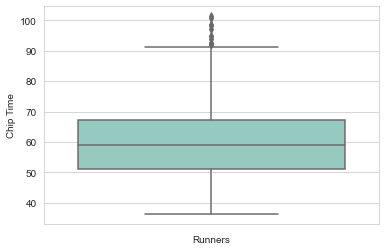

In [157]:
# Plot
ax = sns.boxplot(x = df7["Runner_mins"], palette = "Set3", orient = "v")
plt.ylabel('Chip Time')
plt.xlabel('Runners')
plt.show()

Acima estão as estatísticas de resumo de dados para os corredores mostrados em um boxplot: Máximo, mínimo, médio, primeiro quartil, terceiro quartil, incluindo valores extremos.

Criaremos agora um gráfico de distribuição dos tempos dos chips dos corredores usando a biblioteca seaborn.

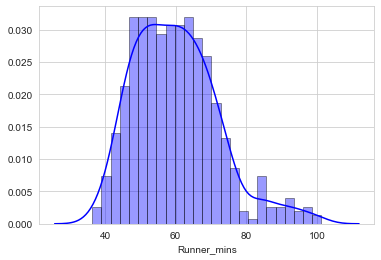

In [158]:
# Plot
x = df7['Runner_mins']
ax = sns.distplot(x, hist = True, kde = True, rug = False, color = 'blue', bins = 25, hist_kws = {'edgecolor':'black'})
plt.show()

A distribuição da variável parece quase normal. Mas vamos realizar um teste estatístico para confirmar.

Um ponto de decisão importante ao trabalhar com uma amostra de dados é usar métodos estatísticos paramétricos ou não paramétricos.

Os métodos estatísticos paramétricos assumem que os dados têm uma distribuição conhecida e específica, geralmente uma distribuição gaussiana (normal). Se uma amostra de dados não é gaussiana, as suposições dos testes estatísticos paramétricos são violadas e métodos estatísticos não paramétricos devem ser utilizados.

Há várias técnicas que você pode usar para verificar se sua amostra de dados se desvia de uma distribuição gaussiana, chamada testes de normalidade.

O pacote stats do SciPy fornece uma função para um dos testes de normalidade mais comuns, o Shapiro-Wilk Test. Usaremos ainda a função normality do pacote Pengouin.

O Shapiro-Wilk é um teste de hipóteses, que testa essas duas hipóteses:

**A hipótese nula deste teste é que a população é normalmente distribuída. Assim, se o valor-p for menor que o nível alfa escolhido (normalmente definido em 0,05), a hipótese nula será rejeitada e há evidências de que os dados testados não são normalmente distribuídos.**

***O resultado do teste de Shapiro-Wilk deve ser interpretado com cautela no caso de amostras grandes.*** 

##### Aplicando o teste de normalidade para identificar se os dados são normalmente distribuídos.

- pvalue < 5 : Rejeitamos a hipótese nula e considerados os dados como NÃO NORMALMENTE DISTRIBUIDOS.
- pvalue > 5 : Não existe evidências para rejeitar a hipótese nula e consideramos os dados como NORMALMENTE DISTRIBUIDOS.

In [166]:
# Teste de normalidade com Scipy
stats.shapiro(df7['Runner_mins'])

ShapiroResult(statistic=0.9625251889228821, pvalue=5.836563177208376e-11)

In [167]:
# Teste de normalidade com Pingouin
pg.normality(df7['Runner_mins'])

,W,pval,normal
Runner_mins,0.962525,5.836563e-11,False


**Análise**:

- A variável não segue uma distribuição normal, uma vez que o valor-p é menor que 0.05 e assim há evidências estatísticas para rejeitar a hipótese nula. A função normality() do pacote Pingouin coloca essa informação na última coluna.

Vamos agora descobrir se houve alguma diferença de desempenho entre homens e mulheres de várias faixas etárias.

In [168]:
# Separando os dados
f_runners = df7.loc[df7[' Gender'] == ' F']['Runner_mins']
m_runners = df7.loc[df7[' Gender'] == ' M']['Runner_mins']

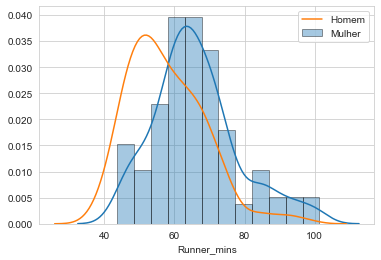

In [163]:
# Criaremos os 2 plots em uma só figura para facilitar a comparação
sns.distplot(f_runners, hist = True, kde = True, rug = False, hist_kws = {'edgecolor':'black'}, label = 'Mulher')
sns.distplot(m_runners, hist = False, kde = True, rug = False, hist_kws = {'edgecolor':'black'}, label = 'Homem')
plt.legend()

**Análise**:

- A distribuição indica que as mulheres eram mais lentas que os homens, em média.

In [164]:
# Computando estatísticas resumidas para homens e mulheres separadamente usando o método groupby ()
g_stats = df7.groupby(" Gender", as_index = True).describe()
g_stats

Runner_mins                                                         \
              count       mean        std        min        25%        50%   
 Gender                                                                      
 F            163.0  66.119223  12.184440  43.766667  58.758333  64.616667   
 M            414.0  57.640821  11.011857  36.350000  49.395833  55.791667   

                                
               75%         max  
 Gender                         
 F       72.058333  101.300000  
 M       64.804167   98.516667

**Análise**:
    
- O tempo médio de chip para todas as mulheres e homens foi de ~ 66 minutos e ~ 58 minutos, respectivamente, comprovando a análise do gráfico. 

Um boxplot ajuda a comparar as amostras de homens e mulheres.

Text(0.5, 0.98, '')

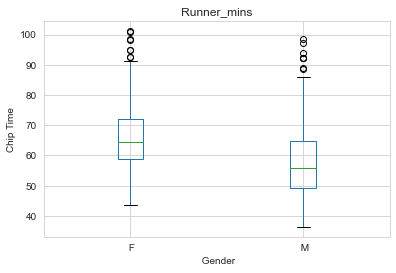

In [165]:
# Plot
df7.boxplot(column = 'Runner_mins', by = ' Gender')
plt.ylabel('Chip Time')
plt.suptitle("")

## Parte 4: Resultado FInal:


##### Análise Geral: 

- O tempo médio de chip para todos os corredores foi de ~ 60 minutos.
- O corredor mais rápido terminou em 36,35 minutos.
- O corredor mais lento terminou em 101,30 minutos.

- A variável não segue uma distribuição normal, uma vez que o valor-p é menor que 0.05 e assim há evidências estatísticas para rejeitar a hipótese nula.

##### Análise por Gênero:

- A distribuição indica que as mulheres eram mais lentas que os homens, em média.
- O tempo médio de chip para todas as mulheres e homens foi de ~ 66 minutos e ~ 58 minutos, respectivamente, comprovando a análise do gráfico. 
